# Customer Segmentation | Online Retail
* 1. Understanding the Dataset
* 2. EDA
*  3. Data-Preprocessing
   * i. Removing Missing Valus
   * ii.Removing Negative transaction
* 4. Distribution of Customer Recency
* 5.Visualize Recency & Frequency vs Monetary
* 6. Customer segmenation using K-means
   * i. Recency Vs Monetary
   * ii. frequency vs Monetary
* 7.Calculation of Silhoutte
   * i. Analysis of Silhoutte score and Analysis of RFM
* 8.Interpretation using K clusters

In [49]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.offline as pyoff
import plotly.graph_objs as go
from lifetimes.utils import summary_data_from_transaction_data

# Read the data
df = pd.read_csv('F:\\python\\OnlineRetail.csv', error_bad_lines=False, encoding= 'unicode_escape')
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [50]:
import datetime as dt
df_ = df[df['Country']=='United Kingdom']
#Transform to proper datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# Remove records with no CustomerID
df_ = df[~df['CustomerID'].isna()]

# Remove negative/0 quantities and prices
df_ = df[df['Quantity']>0]
df_ = df[df['UnitPrice']>0]

# Create sum column for each order line
df_['InvoiceSum'] = df['Quantity']*df['UnitPrice']

def extract_days(x):

    return dt.datetime(x.year, x.month, x.day)

df_['InvoiceDate'] = df['InvoiceDate'].apply(extract_days)
orders = df_.groupby(['InvoiceNo', 'InvoiceDate']).sum().reset_index()

In [51]:
df_.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceSum
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09,4.15,12680.0,France,16.60
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09,4.95,12680.0,France,14.85


In [52]:
df_.describe()

,Quantity,UnitPrice,CustomerID,InvoiceSum
count,539392.000000,539392.000000,406789.000000,539392.000000
mean,9.845904,4.673648,15287.795830,18.112749
std,215.412652,94.614722,1713.573064,379.091706
min,-80995.000000,0.001000,12346.000000,-168469.600000
25%,1.000000,1.250000,13954.000000,3.750000
50%,3.000000,2.080000,15152.000000,9.840000
75%,10.000000,4.130000,16791.000000,17.400000
max,80995.000000,38970.000000,18287.000000,168469.600000


In [57]:
df1 = df_[df_.Quantity > 0]
df1 = df1[df1.UnitPrice > 0]
df1 = df1[pd.notnull(df1['CustomerID'])]
df1['TotalPrice'] = df1['Quantity']*df1['UnitPrice']
df1['CustomerID'].count()

397884

In [58]:
import datetime as dt
NOW = dt.date(2011,12,9)

df1['date'] = pd.DatetimeIndex(df1.InvoiceDate).date


df_recency = df1.groupby(['CustomerID'],as_index=False)['date'].max()
df_recency.columns = ['CustomerID','Last_Purchase_Date']

df_recency['Recency'] = df_recency.Last_Purchase_Date.apply(lambda x:(NOW - x).days)


In [59]:
df_recency.head()

,CustomerID,Last_Purchase_Date,Recency
0,12346.0,2011-01-18,325
1,12347.0,2011-12-07,2
2,12348.0,2011-09-25,75
3,12349.0,2011-11-21,18
4,12350.0,2011-02-02,310


In [60]:
df_recency.drop(columns=['Last_Purchase_Date'],inplace=True)


FM_Table = df1.groupby('CustomerID').agg({'InvoiceNo'   : lambda x:len(x),
                                         'TotalPrice'  : lambda x:x.sum()})

FM_Table.rename(columns = {'InvoiceNo' :'Frequency',
                           'TotalPrice':'Monetary_Value'},inplace= True)

RFM_Table = df_recency.merge(FM_Table,left_on='CustomerID',right_on='CustomerID')
RFM_Table.head()


# Filter out monetary outliers
RFM_Table = RFM_Table[RFM_Table['Monetary_Value']<2000]
RFM_Table = RFM_Table[RFM_Table['Frequency']>0]

RFM_Table.head()

,CustomerID,Recency,Frequency,Monetary_Value
2,12348.0,75,31,1797.24
3,12349.0,18,73,1757.55
4,12350.0,310,17,334.40
6,12353.0,204,4,89.00
7,12354.0,232,58,1079.40


In [61]:
RFM_Table['CustomerID'].count()

3435

Now we split the metrics into segments using quantiles.We assign a score from 1 to 4 to Recency, Frequency and Monetary. 4 is the best/highest value, and 1 is the lowest/worst value. A final RFM score is calculated simply by combining individual RFM score numbers.

In [62]:
quantiles = RFM_Table.quantile(q=[0.25,0.50,0.75])
quantiles = quantiles.to_dict()

segmented_rfm = RFM_Table.copy()


def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [63]:
segmented_rfm['R_quartile'] = segmented_rfm['Recency'].apply(RScore, args=('Recency',quantiles))
segmented_rfm['F_quartile'] = segmented_rfm['Frequency'].apply(FMScore, args=('Frequency',quantiles))
segmented_rfm['M_quartile'] = segmented_rfm['Monetary_Value'].apply(FMScore, args=('Monetary_Value',quantiles))
segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary_Value,R_quartile,F_quartile,M_quartile
2,12348.0,75,31,1797.24,2,3,4
3,12349.0,18,73,1757.55,4,4,4
4,12350.0,310,17,334.40,1,2,2
6,12353.0,204,4,89.00,1,1,1
7,12354.0,232,58,1079.40,1,3,4


Best Recency score = 4: Purchased very recently. Best Frequency score = 4: highest quantity purchases. Best Monetary score = 4: spent the most.



In [64]:
segmented_rfm['RFM_Segment'] = segmented_rfm.R_quartile.map(str)+segmented_rfm.F_quartile.map(str)+segmented_rfm.M_quartile.map(str)
segmented_rfm.head()


segmented_rfm['RFM_Score'] = segmented_rfm[['R_quartile','F_quartile','M_quartile']].sum(axis=1)
segmented_rfm.tail()

,CustomerID,Recency,Frequency,Monetary_Value,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score
4332,18278.0,73,9,173.90,2,1,1,211,4
4333,18280.0,277,10,180.60,1,1,1,111,3
4334,18281.0,180,7,80.82,1,1,1,111,3
4335,18282.0,7,12,178.05,4,1,1,411,6
4337,18287.0,42,70,1837.28,3,4,4,344,11


In [77]:
# Create human friendly RFM labels
segt_map = {
    r'[1-2][1-2][1-4]': 'Hibernating',
    r'[1-2][2-3][1-4]': 'At risk',
    r'[1-2]4[1-4]': 'Can\'t loose them',
    r'2[1-2][1-4]': 'About to sleep',
    r'22[1-4]': 'Need attention',
    r'[2-3][3-4][1-4]': 'Loyal customers',
    r'[3][1][1-4]': 'Promising',
    r'[4][1][1-4]': 'New customers',
    r'[3-4][1-2][1-4]': 'Potential loyalists',
    r'4[3-4][1-4]': 'Champions'
}

segmented_rfm['Customer_Segment'] = segmented_rfm['R_quartile'].map(str) + segmented_rfm['F_quartile'].map(str)+ segmented_rfm['M_quartile'].map(str)
segmented_rfm['Customer_Segment'] = segmented_rfm['Customer_Segment'].replace(segt_map, regex=True)

In [78]:
segmented_rfm

,CustomerID,Recency,Frequency,Monetary_Value,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score,Customer_Segment
2,12348.0,75,31,1797.24,2,3,4,234,9,At risk
3,12349.0,18,73,1757.55,4,4,4,444,12,Champions
4,12350.0,310,17,334.40,1,2,2,122,5,Hibernating
6,12353.0,204,4,89.00,1,1,1,111,3,Hibernating
7,12354.0,232,58,1079.40,1,3,4,134,8,At risk
...,...,...,...,...,...,...,...,...,...,...
4332,18278.0,73,9,173.90,2,1,1,211,4,Hibernating
4333,18280.0,277,10,180.60,1,1,1,111,3,Hibernating
4334,18281.0,180,7,80.82,1,1,1,111,3,Hibernating
4335,18282.0,7,12,178.05,4,1,1,411,6,New customers


In [79]:
segmented_rfm.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary_Value': ['mean', 'count'] }).round(1)

Recency Frequency Monetary_Value      
             mean      mean           mean count
RFM_Score                                       
3           276.5       7.0          137.7   274
4           197.1      10.9          201.5   262
5           171.6      16.1          283.1   399
6           117.2      19.8          363.4   416
7           102.8      29.4          486.3   373
8            83.7      39.5          615.0   385
9            69.3      54.4          803.9   377
10           44.4      74.2          983.9   385
11           26.0     104.5         1187.8   320
12           10.9     136.7         1460.0   244

K-means gives the best result under the following conditions:

Data’s distribution is not skewed.
Data is standardised (i.e. mean of 0 and standard deviation of 1).

In [80]:
segmented_rfm.groupby('Customer_Segment').count()

,CustomerID,Recency,Frequency,Monetary_Value,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score
Customer_Segment,,,,,,,,,
At risk,388,388,388,388,388,388,388,388,388
Can't loose them,220,220,220,220,220,220,220,220,220
Champions,608,608,608,608,608,608,608,608,608
Hibernating,1091,1091,1091,1091,1091,1091,1091,1091,1091
Loyal customers,500,500,500,500,500,500,500,500,500
New customers,127,127,127,127,127,127,127,127,127
Potential loyalists,336,336,336,336,336,336,336,336,336
Promising,165,165,165,165,165,165,165,165,165


In [81]:
segmented_rfm['CustomerID'].count()

3435

In [82]:
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
#from scipy.stats.mstats import winsorize

#from feature_engine.outlier_removers import Winsorizer

In [83]:
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

Recency's: Skew: 0.9998840950617494, : SkewtestResult(statistic=20.214398201507812, pvalue=7.313172668977651e-91)
Frequency's: Skew: 2.9323586473200223, : SkewtestResult(statistic=39.037744455137954, pvalue=0.0)
Monetary_Value's: Skew: 0.9671990167560796, : SkewtestResult(statistic=19.71280320714967, pvalue=1.6743016327671492e-86)


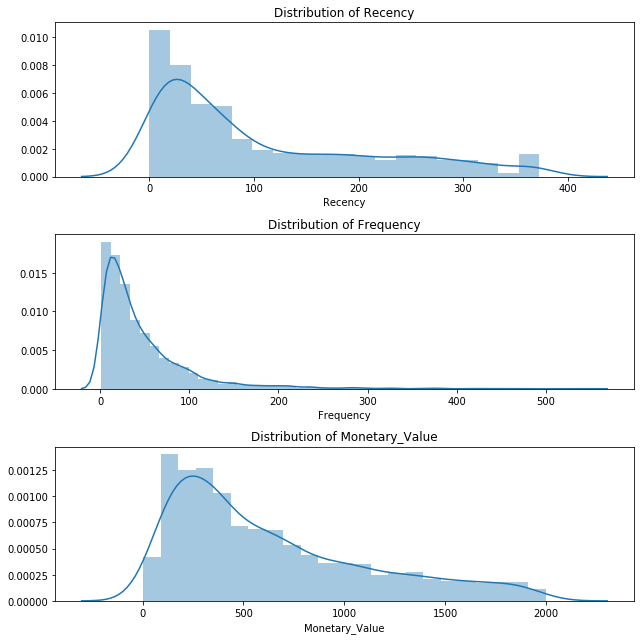

In [84]:
# Plot all 3 graphs together for summary findings
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(RFM_Table,'Recency')

plt.subplot(3, 1, 2)
check_skew(RFM_Table,'Frequency')

plt.subplot(3, 1, 3)
check_skew(RFM_Table,'Monetary_Value')

plt.tight_layout()
plt.savefig('before_transform.png', format='png', dpi=1000)

The data is highly skewed,therefore we will perform log transformations to reduce the skewness of each variable.I add a small constant as log transformation demands all the values to be positive.

Recency's: Skew: -0.5943012120501298, : SkewtestResult(statistic=-13.227976210961797, pvalue=6.049438941927319e-40)
Frequency's: Skew: -0.26982581067256706, : SkewtestResult(statistic=-6.35850710896685, pvalue=2.0372395865092336e-10)
Monetary_Value's: Skew: -0.5102184914076575, : SkewtestResult(statistic=-11.556228931990637, pvalue=6.865820821805074e-31)


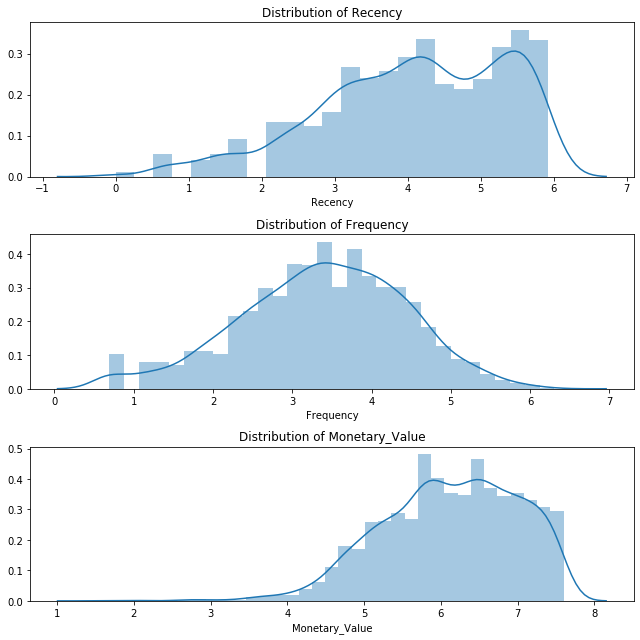

In [85]:
RFM_log = RFM_Table.copy()

RFM_log_ = np.log(RFM_log+1)

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(RFM_log_,'Recency')

plt.subplot(3, 1, 2)
check_skew(RFM_log_,'Frequency')

plt.subplot(3, 1, 3)
check_skew(RFM_log_,'Monetary_Value')

plt.tight_layout()
#plt.savefig('after_transform.png', format='png', dpi=1000)


In [86]:
RFM_Table.describe()


,CustomerID,Recency,Frequency,Monetary_Value
count,3435.000000,3435.000000,3435.000000,3435.000000
mean,15360.437555,107.546434,47.021252,637.837692
std,1699.278846,104.077073,53.195635,490.331024
min,12348.000000,0.000000,1.000000,3.750000
25%,13887.500000,24.000000,14.000000,248.260000
50%,15392.000000,65.000000,29.000000,483.800000
75%,16811.500000,176.000000,61.000000,920.305000
max,18287.000000,373.000000,547.000000,1998.000000


In [127]:
#from feature_engine.outlier_removers import Winsorizer

#windsoriser = Winsorizer(distribution='skewed', 
                    #     tail='both', # cap left, right or both tails 
                    #      fold=2,
                    #       variables=[ 'Recency', 'Frequency', 'Monetary_Value']
                    #    )

#windsoriser.fit(RFM_log_)

#df_rfm_log = windsoriser.transform(RFM_log_)


In [122]:
scaler = StandardScaler()

scaler.fit(RFM_log_)

RFM_log_scaled = scaler.transform(RFM_log_)
RFM_log_scaled = pd.DataFrame(RFM_log_scaled, columns=RFM_log_.columns)


## K-Means Clustering
Finding the optimal number of clusters

In [123]:
from scipy.spatial.distance import cdist

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(RFM_log_scaled) 
    kmeanModel.fit(RFM_log_scaled)     
      
    distortions.append(sum(np.min(cdist(RFM_log_scaled, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / RFM_log_scaled.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(RFM_log_scaled, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / RFM_log_scaled.shape[0] 
    mapping2[k] = kmeanModel.inertia_

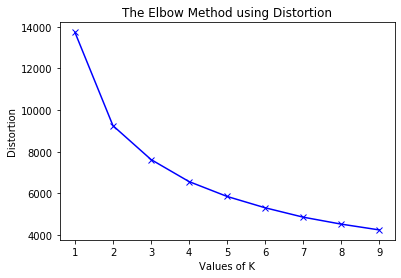

In [124]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

The cluster value where this decrease in inertia value becomes constant can be chosen as the right cluster value for our data. Looking at the above elbow curve, we can choose any number of clusters between 4 to 7.

In [125]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

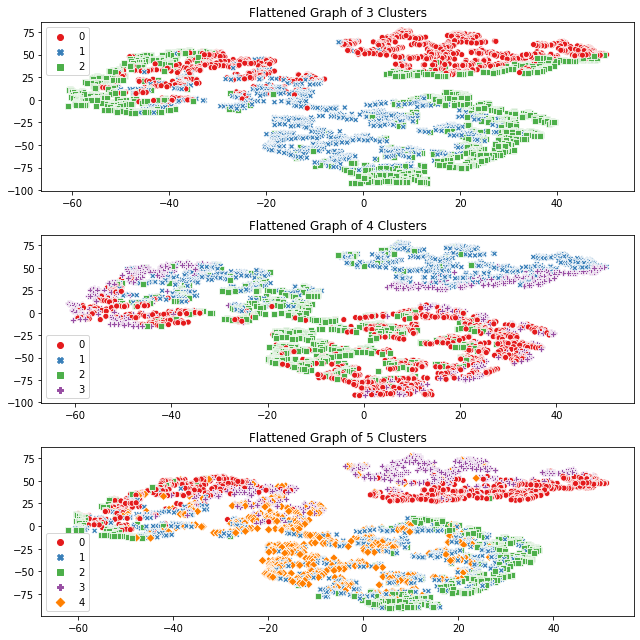

In [126]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
df_rfm_k3 = kmeans(RFM_log_scaled, 3, RFM_Table)

plt.subplot(3, 1, 2)
df_rfm_k4 = kmeans(RFM_log_scaled, 4, RFM_Table)

plt.subplot(3, 1, 3)
df_rfm_k5 = kmeans(RFM_log_scaled, 5, RFM_Table)

plt.tight_layout()
#plt.savefig('flattened.png', format='png', dpi=1000)

In [128]:
def snake_plot(normalised, kmeans, RFM_Table):

    normalised = pd.DataFrame(normalised, 
                                       index=RFM_Table.index, 
                                       columns=RFM_Table.columns)
    normalised['Cluster'] = kmeans['Cluster']

    # Melt data into long format
    df_melt = pd.melt(normalised.reset_index(), 
                        id_vars=['CustomerID', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary_Value'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

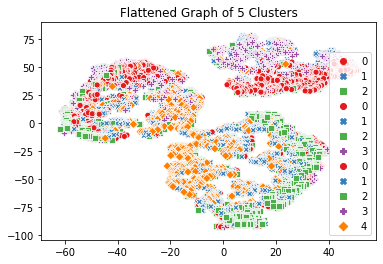

In [129]:
k3 = kmeans(RFM_log_scaled, 3, RFM_Table)
k4 = kmeans(RFM_log_scaled, 4, RFM_Table)
k5 = kmeans(RFM_log_scaled, 5, RFM_Table)

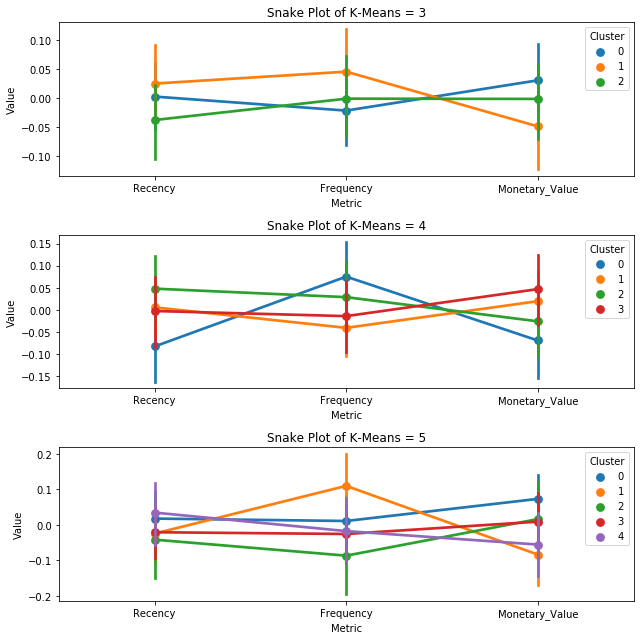

In [130]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of K-Means = 3')
snake_plot(RFM_log_scaled, k3, RFM_Table)

plt.subplot(3, 1, 2)
plt.title('Snake Plot of K-Means = 4')
snake_plot(RFM_log_scaled, k4, RFM_Table)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of K-Means = 5')
snake_plot(RFM_log_scaled, k5, RFM_Table)

plt.tight_layout()


From the flattened graphs and the snake plots it is evident that having a cluster value of 4,segments our customers well. We could also go for higher number of clusters, it completely depends on how the company wants to segment their customers.

## Interpretation of the clusters formed using k-means 

In [131]:
def rfm_values(df):

    df_new = df.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary_Value': ['mean', 'count']
    }).round(0)
    
    return df_new

In [132]:
rfm_values(k4)


Recency Frequency Monetary_Value      
           mean      mean           mean count
Cluster                                       
0         139.0      31.0          442.0   967
1          96.0      45.0          793.0   910
2          27.0     101.0         1087.0   838
3         174.0       8.0          182.0   720

## conclusion

* The First cluster is more related to the "Almost Lost" segment as they Haven’t purchased for some time(R=3), but used to purchase frequently and spent a lot.
* The Second cluster are very Loyal Customers and they also spent a lot.
* The Third cluster belongs to the "Best Customers" segment which we saw earlier as they purchase recently (R=4), frequent buyers (F=4), and spent the most (M=4).
* Customers in the Fourth cluster can be interpreted as passerby customers as their last purchase is long ago (R=1),purchased very few (F=1) and spent little (M=1).Company has to come up with new strategies to make them permanent members.

